In [21]:
from PIL import Image, ImageOps
import numpy as np
import pandas as pd
import os
from scipy.stats import ttest_ind, shapiro, levene
from sklearn.utils.extmath import randomized_svd
import matplotlib.pyplot as plt
from itertools import combinations
from hotelling.stats import hotelling_t2

In [22]:
def calculate_and_store_SVD():
    df = pd.read_csv('data/filtered_df2.csv')
    image_files = list(df['Image']) 

    sample_img = Image.open("data/eyeball_img/" + image_files[0])
    M, N = sample_img.size
    print(f"Image Dimensions: {M}, {N}")

    images_array = np.zeros((len(image_files), M * N), dtype=np.float32)

    for i, file in enumerate(image_files):
        print(i)
        img = Image.open("data/eyeball_img/" + file).convert('RGB')
        img = ImageOps.grayscale(img)
        img_array = np.asarray(img, dtype=np.float32) / 255.0  # normalize to [0,1]
        images_array[i, :] = img_array.flatten()  # flatten

    # Perform randomized SVD
    U, S, Vt = randomized_svd(images_array, n_components=100, random_state=42)

    # No need to sort! randomized_svd already sorts singular values descending

    np.savez("grayscale_svd_results2.npz", U=U, S=S, Vt=Vt)

In [ ]:
def plot_top_singular_values():
    data = np.load("grayscale_svd_results2.npz")
    U, S, Vt = data["U"], data["S"], data["Vt"]
    top_2_U = U[:, :2]
    top_2_S = S[:2]
    top_2_coefficients = top_2_U * top_2_S
    print(np.shape(top_2_U))
    df = pd.read_csv('data/filtered_df2.csv')
    df['top_1_coefficient'] = top_2_coefficients[:, 0]  # First singular vector coefficient
    df['top_2_coefficient'] = top_2_coefficients[:, 1]  # Second singular vector coefficient
    display(df)

    colors = []
    for index, row in df.iterrows():
        if row['N'] == 1:
            colors.append('grey')
        elif row['D'] == 1:
            colors.append('red')
        elif row['G'] == 1:
            colors.append('yellow')
        elif row['C'] == 1:
            colors.append('green')
        elif row['A'] == 1:
            colors.append('orange')
        elif row['H'] == 1:
            colors.append('pink')
        elif row['M'] == 1:
            colors.append('blue')
        elif row['O'] == 1:
            colors.append('purple')
    df.plot.scatter(x='top_1_coefficient', y='top_2_coefficient', c=colors)
    plt.show()
    plt.clf()
    df[df['N'] == 1].plot.scatter(x='top_1_coefficient', y='top_2_coefficient', c='grey')
    plt.xlim(0, 600)
    plt.ylim(-100, 200)
    plt.show()
    df[df['D'] == 1].plot.scatter(x='top_1_coefficient', y='top_2_coefficient', c='red')
    plt.xlim(0, 600)
    plt.ylim(-100, 200)
    plt.show()
    df[df['G'] == 1].plot.scatter(x='top_1_coefficient', y='top_2_coefficient', c='yellow')
    plt.xlim(0, 600)
    plt.ylim(-100, 200)
    plt.show()
    df[df['C'] == 1].plot.scatter(x='top_1_coefficient', y='top_2_coefficient', c='green')
    plt.xlim(0, 600)
    plt.ylim(-100, 200)
    plt.show()
    df[df['A'] == 1].plot.scatter(x='top_1_coefficient', y='top_2_coefficient', c='orange')
    plt.xlim(0, 600)
    plt.ylim(-100, 200)
    plt.show()
    df[df['H'] == 1].plot.scatter(x='top_1_coefficient', y='top_2_coefficient', c='pink')
    plt.xlim(0, 600)
    plt.ylim(-100, 200)
    plt.show()
    df[df['M'] == 1].plot.scatter(x='top_1_coefficient', y='top_2_coefficient', c='blue')
    plt.xlim(0, 600)
    plt.ylim(-100, 200)
    plt.show()
    df[df['O'] == 1].plot.scatter(x='top_1_coefficient', y='top_2_coefficient', c='purple')
    plt.xlim(0, 600)
    plt.ylim(-100, 200)
    plt.show()

    indicators = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']

    # create an 8x8 grid of subplots
    fig, axes = plt.subplots(8, 8, figsize=(20, 20))
    for i in range(8):
        for j in range(8):
            var1 = indicators[i]
            var2 = indicators[j]

            # points where var1 == 1 and var2 == 0 (first class)
            class_1 = df[(df[var1] == 1) & (df[var2] == 0)]
            # points where var1 == 0 and var2 == 1 (second class)
            class_2 = df[(df[var1] == 0) & (df[var2] == 1)]

            axes[i, j].scatter(class_1['top_1_coefficient'], class_1['top_2_coefficient'], color='red', label=var1, alpha=0.2)
            axes[i, j].scatter(class_2['top_1_coefficient'], class_2['top_2_coefficient'], color='blue', label=var2, alpha=0.2)
            
            axes[i, j].set_xlabel('Top Singular Vector 1')
            axes[i, j].set_ylabel('Top Singular Vector 2')
            axes[i, j].set_title(f'{var1} vs {var2}')

            axes[i, j].legend()

    plt.tight_layout()
    plt.show()
    plt.clf()

In [24]:
#calculate_and_store_SVD()

(2589, 2)


,Unnamed: 0,ID,Image,N,D,G,C,A,H,M,O,top_1_coefficient,top_2_coefficient
0,0,0,0_eyes.jpg,0,0,0,1,0,0,0,0,197.771408,10.538239
1,1,1,1_eyes.jpg,1,0,0,0,0,0,0,0,326.225983,-20.718992
2,2,5,5_eyes.jpg,0,1,0,0,0,0,0,0,254.953644,39.227261
3,3,8,8_eyes.jpg,1,0,0,0,0,0,0,0,236.235229,-14.688188
4,4,9,9_eyes.jpg,0,0,0,0,0,0,0,1,361.634094,-12.052473
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2584,2584,4683,4683_eyes.jpg,0,1,0,0,0,0,0,0,186.127426,-5.548799
2585,2585,4686,4686_eyes.jpg,0,1,0,0,0,0,0,0,392.131897,-24.751905
2586,2586,4688,4688_eyes.jpg,0,1,0,0,0,0,0,0,250.203278,5.904832
2587,2587,4689,4689_eyes.jpg,0,1,0,0,0,0,0,0,284.732849,-3.371256


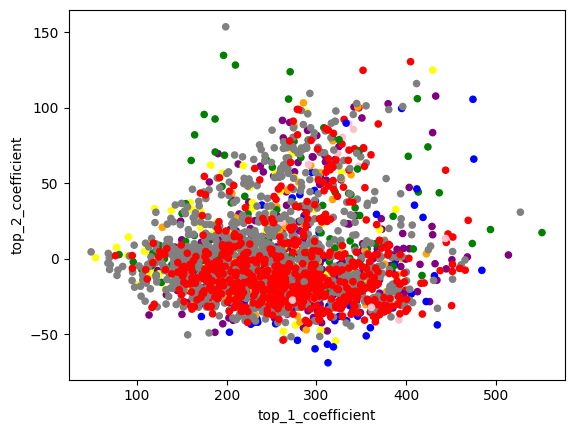

<Figure size 640x480 with 0 Axes>

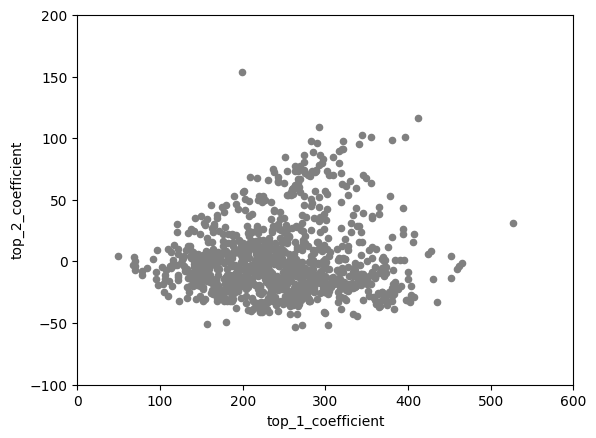

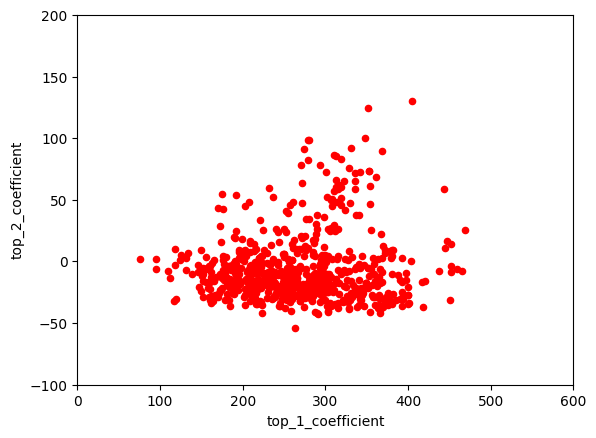

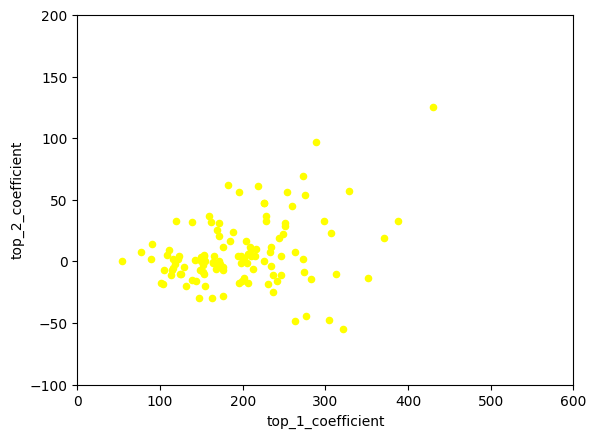

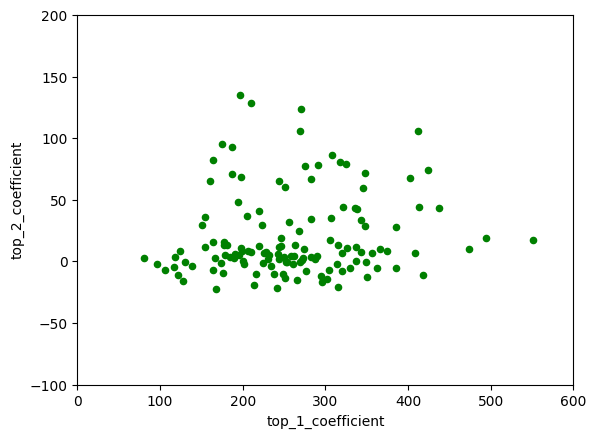

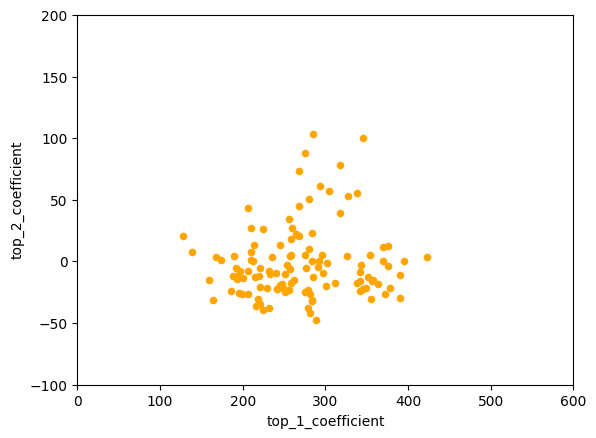

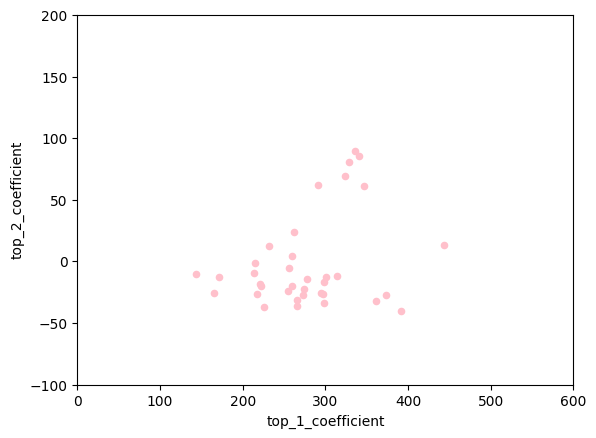

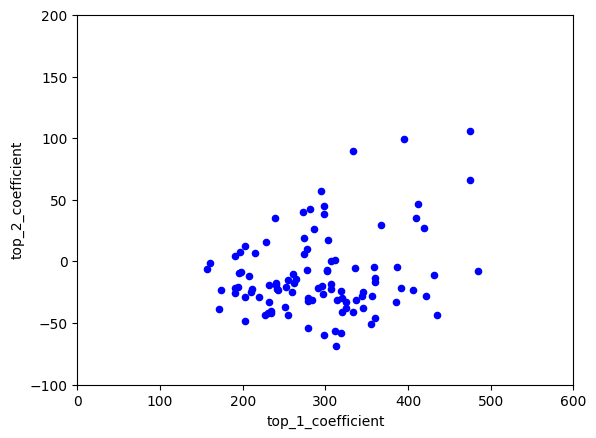

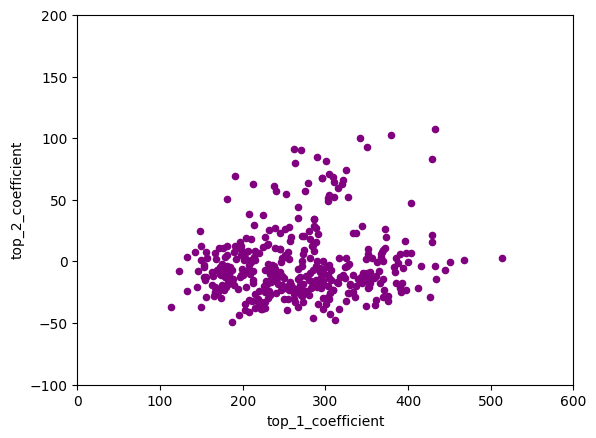

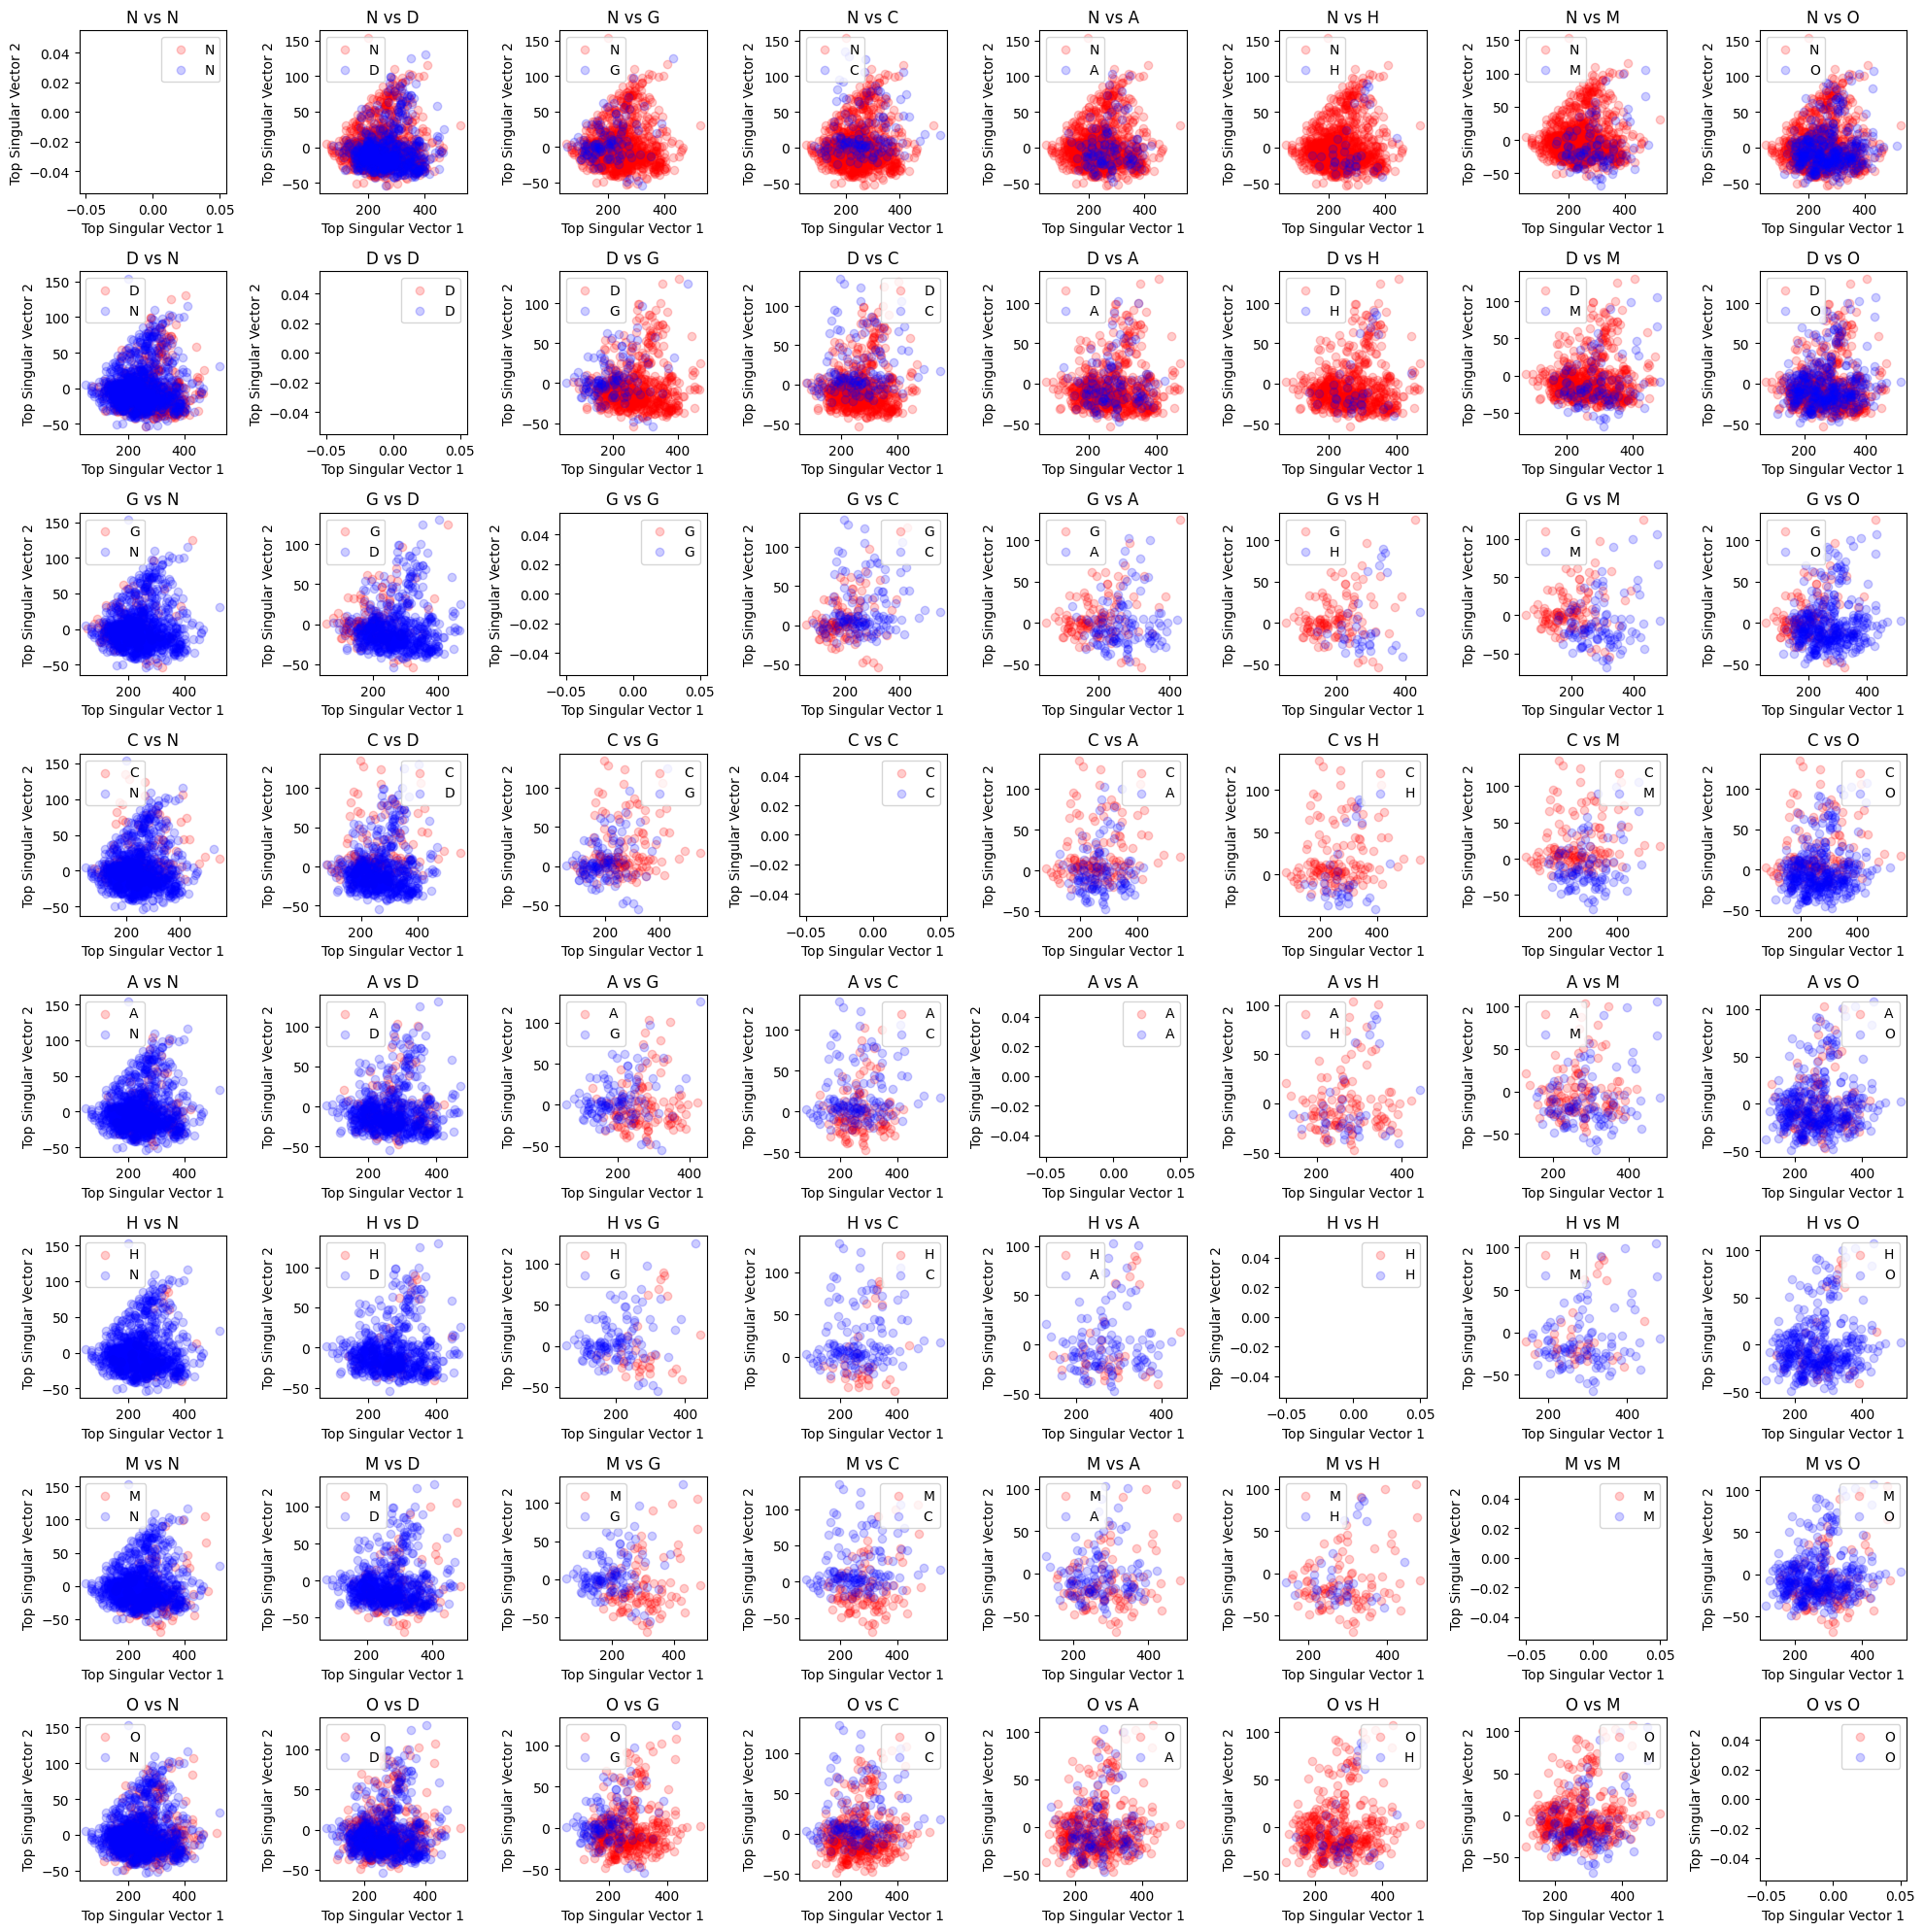

<Figure size 640x480 with 0 Axes>

In [25]:
plot_top_singular_values()